In [62]:
 %config IPCompleter.greedy=True

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk

# SPAM/HAM Dataset Analysis

## Importing Dataset

In [257]:
dataset_path = "../dataset/spam.csv"
df = pd.read_csv(dataset_path, sep=",", encoding="latin-1")
df = df.rename(columns={"v1": "class", "v2": "text"})
df = df.drop(df.columns[2:], axis=1)

In [99]:
df.head()

,class,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Preparing dataset : Tokenizing and deleting stopwords



Deleting "stop word" (most common words that don't give much insight on the data).

In [100]:
nltk.download('stopwords')

stopwords = nltk.corpus.stopwords.words('english')
tokenizer = nltk.RegexpTokenizer(r'\w+')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\matth\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [101]:

def tokenize_sentence_filter_stop_words(sentence):
    return [token.lower() for token in  tokenizer.tokenize(sentence)
                if token not in stopwords]


import time

tokenized_messages = []

start_time = time.time()

for i in df["text"]:
    tokenized_messages.append(tokenize_sentence_filter_stop_words(i))
    
print("--- Tokenized messages in %s seconds ---" % (time.time() - start_time))


--- Tokenized messages in 0.14895892143249512 seconds ---


In [110]:
n_of_messages = np.size(tokenized_messages)

D:\Anaconda\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [105]:
df['tokenized_text_list'] = tokenized_messages

In [111]:
list_str = []
for i in range(n_of_messages):
    list_as_str = ' '.join(tokenized_messages[i])
    list_str.append(list_as_str)

In [112]:
df['tokenized_text_string'] = list_str

In [113]:
df.head()

,class,text,tokenized_text_list,tokenized_text_string
0,ham,"Go until jurong point, crazy.. Available only ...","[go, jurong, point, crazy, available, bugis, n...",go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,"[ok, lar, joking, wif, u, oni]",ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, 2, wkly, comp, win, fa, cup, fin...",free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,"[u, dun, say, early, hor, u, c, already, say]",u dun say early hor u c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...","[nah, i, think, goes, usf, lives, around, though]",nah i think goes usf lives around though


## Displaying most used Words (Word Cloud)

In [114]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_n_words(corpus, n=None):
    """
    List the top n words in a vocabulary according to occurrence in a text corpus.
    
    get_top_n_words(["I love Python", "Python is a language programming", "Hello world", "I love the world"]) -> 
    [('python', 2),
     ('world', 2),
     ('love', 2),
     ('hello', 1),
     ('is', 1),
     ('programming', 1),
     ('the', 1),
     ('language', 1)]
    """
    vec = CountVectorizer(stop_words=frozenset(stopwords)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]



In [115]:
get_top_n_words(df["tokenized_text_string"])

[('call', 591),
 ('get', 391),
 ('ur', 385),
 ('gt', 318),
 ('lt', 316),
 ('ok', 292),
 ('free', 284),
 ('go', 280),
 ('know', 261),
 ('like', 245),
 ('good', 245),
 ('got', 239),
 ('day', 229),
 ('come', 229),
 ('time', 220),
 ('love', 209),
 ('send', 199),
 ('want', 194),
 ('text', 193),
 ('txt', 177),
 ('one', 175),
 ('going', 173),
 ('need', 168),
 ('home', 167),
 ('lor', 162),
 ('today', 160),
 ('sorry', 160),
 ('see', 158),
 ('stop', 158),
 ('still', 157),
 ('back', 153),
 ('da', 150),
 ('reply', 148),
 ('dont', 144),
 ('mobile', 142),
 ('take', 139),
 ('tell', 138),
 ('hi', 138),
 ('new', 136),
 ('later', 135),
 ('pls', 134),
 ('please', 133),
 ('think', 132),
 ('week', 126),
 ('phone', 126),
 ('dear', 122),
 ('ì_', 120),
 ('well', 118),
 ('much', 116),
 ('great', 115),
 ('night', 115),
 ('oh', 114),
 ('claim', 113),
 ('hope', 113),
 ('hey', 112),
 ('msg', 111),
 ('wat', 107),
 ('happy', 107),
 ('yes', 103),
 ('make', 102),
 ('way', 102),
 ('www', 100),
 ('work', 100),
 ('give',

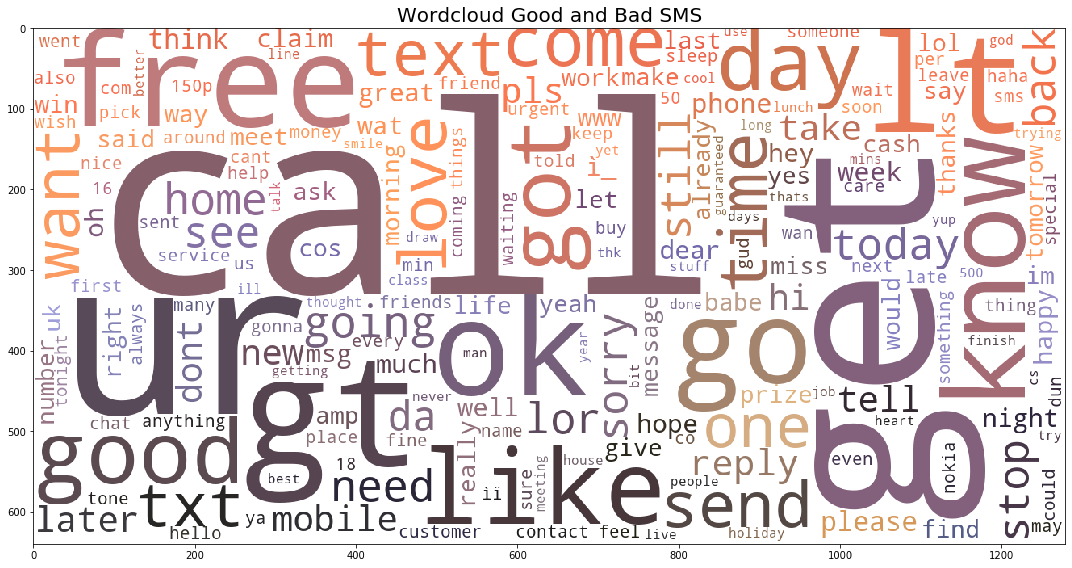

In [117]:
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator


def generate_word_cloud(df_col, title="wordcloud"):
    word_frequencies = get_top_n_words(df_col)    
    
    char_mask = np.array(Image.open("../docs/berkeley-background.jpeg")) # you can choose your own image for the colors
    image_colors = ImageColorGenerator(char_mask)

    word_frequencies_dict = {}

    for word, freq in word_frequencies:
        word_frequencies_dict[word] = freq


    wc = WordCloud(background_color="white", max_words=200, width=10000, height=1000, mask=char_mask, random_state=1)
    wc.generate_from_frequencies(word_frequencies_dict)
    # to recolour the image
    fig = plt.gcf()
    plt.title(title, fontsize=20)
    fig.set_size_inches(18.5, 10.5)
    plt.imshow(wc.recolor(color_func=image_colors))
    
generate_word_cloud(df["tokenized_text_string"], "Wordcloud Good and Bad SMS")

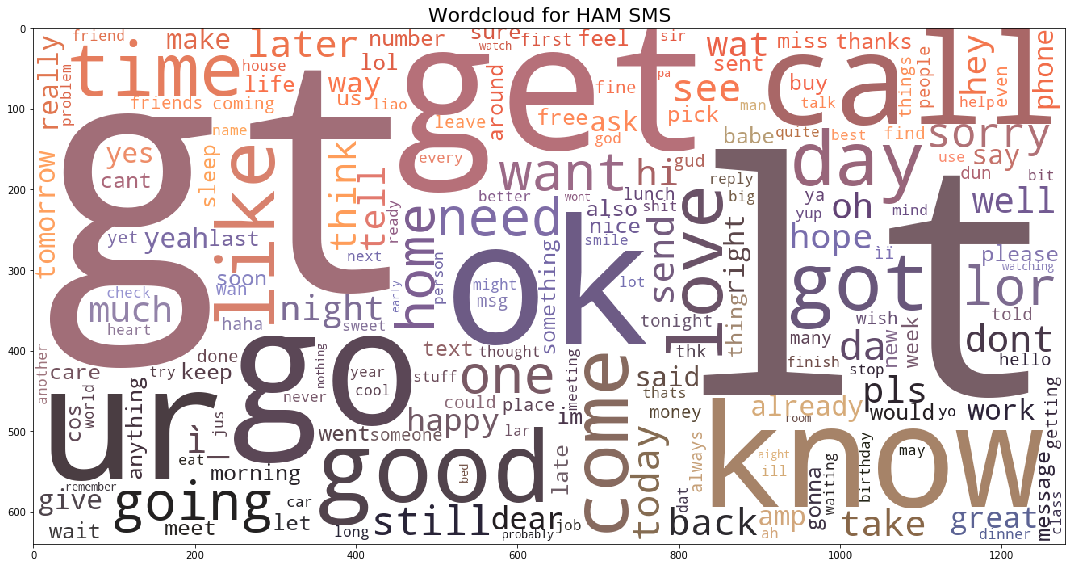

In [118]:
generate_word_cloud(df[df["class"] == "ham"]["tokenized_text_string"], "Wordcloud for HAM SMS")

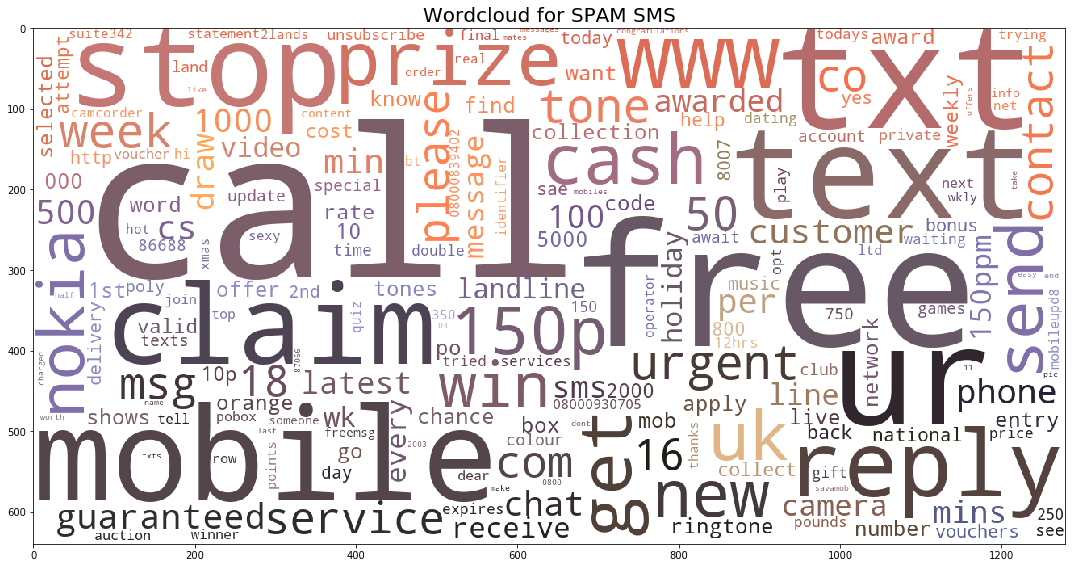

In [119]:
generate_word_cloud(df[df["class"] == "spam"]["tokenized_text_string"], "Wordcloud for SPAM SMS")

## Theme Analysis

In [120]:
from sklearn.feature_extraction.text import CountVectorizer

tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=10000, stop_words=frozenset(stopwords))
tf = tf_vectorizer.fit_transform(df["text"])


### Using LDA

In [121]:
from sklearn.decomposition import LatentDirichletAllocation

n_topics = 10

lda = LatentDirichletAllocation(
        n_components=n_topics, 
        max_iter=5, 
        learning_method='online', 
        learning_offset=50.,
        random_state=0)

lda.fit(tf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=50.0,
                          max_doc_update_iter=100, max_iter=5,
                          mean_change_tol=0.001, n_components=10, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [122]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda, tf_vectorizer.get_feature_names(), no_top_words)

Topic 0:
gt lt know like get yeah got sure buy need
Topic 1:
time oh first sleep work night late anything hey yet
Topic 2:
ok going home ì_ need dont tomorrow today come mins
Topic 3:
lor go got wat already wan dun back ok ìï
Topic 4:
da day said make happy nice went right babe birthday
Topic 5:
ur get take hi new great txt come send week
Topic 6:
much say pick cant one always think never better god
Topic 7:
good love get give life dear thanks well want morning
Topic 8:
call pls sorry later send number please yes cool message
Topic 9:
call free mobile prize claim www text cash txt contact


In [256]:
import string

from nltk.corpus import stopwords

def text_process(mess):
    nopunc =[char for char in mess if char not in string.punctuation]
    nopunc=''.join(nopunc)
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

df['text'].apply(text_process)

0       [Go, jurong, point, crazy, Available, bugis, n...
1                          [Ok, lar, Joking, wif, u, oni]
2       [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3           [U, dun, say, early, hor, U, c, already, say]
4       [Nah, dont, think, goes, usf, lives, around, t...
                              ...                        
5567    [2nd, time, tried, 2, contact, u, U, å£750, Po...
5568                   [Ì, b, going, esplanade, fr, home]
5569                     [Pity, mood, Soany, suggestions]
5570    [guy, bitching, acted, like, id, interested, b...
5571                                   [Rofl, true, name]
Name: text, Length: 5572, dtype: object

In [195]:
df.head()

,class,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [196]:


#bow_transformer = CountVectorizer(analyzer=text_process).fit(df['text'])
#print(len(bow_transformer.vocabulary_))

#text_bow = bow_transformer.transform(df['text'])

11304


In [197]:

#tfidf_transformer=TfidfTransformer().fit(text_bow)

In [198]:
#print(tfidf_transformer.idf_[bow_transformer.vocabulary_['love']])
#print(tfidf_transformer.idf_[bow_transformer.vocabulary_['Free']])

4.773658523649919
5.775541185859478


In [201]:
#text_tfidf=tfidf_transformer.transform(text_bow)
#print(text_tfidf.shape)

(5572, 11304)


In [258]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test  = train_test_split(df['text'],df['class'],test_size=0.2, random_state = 42)

In [259]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(max_features = 1500)
cv.fit(X_train)

X_train_cv = cv.transform(X_train)

X_test_cv = cv.transform(X_test)

mnb = MultinomialNB(alpha = 0.5)
mnb.fit(X_train_cv,y_train)

y_mnb = mnb.predict(X_test_cv)

print('Naive Bayes Accuracy: ', accuracy_score( y_mnb , y_test))

print('Naive Bayes confusion_matrix: ', confusion_matrix(y_mnb, y_test))

Naive Bayes Accuracy:  0.9829596412556054
Naive Bayes confusion_matrix:  [[960  14]
 [  5 136]]


In [1]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
   ( 'bow',CountVectorizer(analyzer=text_process)),
    ('tfidf',TfidfTransformer()),
    ('classifier',mnb),
])


pipeline.fit(X_train,y_train)

joblib.dump(pipeline, 'pipeline.pkl')

NameError: name 'CountVectorizer' is not defined

In [261]:
predictions = pipeline.predict(X_test)
print('Naive Bayes Accuracy_score: ', accuracy_score(y_test,predictions))

Naive Bayes Accuracy_score:  0.9739910313901345


In [262]:
tweet = "win a free iphone with this link"

sample_predict = pipeline.predict([tweet])

print(sample_predict)

['spam']


In [244]:
######

In [3]:
from ipynb.fs.full.modbot import textprocess

ModuleNotFoundError: No module named 'ipynb'

In [4]:
pip install ipynb

Note: you may need to restart the kernel to use updated packages.


In [8]:
from ipynb.fs.full.modbot import text_process